In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys 
from pyprojroot import here
sys.path.insert(0, str(here()))
from os.path import exists

import geopandas as gpd
from laos_gggi.data_functions import load_emdat_data, load_shapefile, load_rivers_data
from laos_gggi.data_functions.disaster_point_data import (load_disaster_point_data, 
                    load_synthetic_non_disaster_points, load_grid_point_data, load_non_disaster_grid)

from laos_gggi.plotting import configure_plot_style
from laos_gggi.statistics import get_distance_to_rivers, prediction_to_gpd_df , set_plotting_data, add_data, add_country_effect
from laos_gggi.data_functions.combine_data import load_all_data
from pymc.model.transform.optimization import freeze_dims_and_data

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import arviz as az
import scipy
import nutpie
import pathlib

import pymc as pm
import pytensor.tensor as pt
from laos_gggi.sample import sample_or_load


from laos_gggi.transformers import Standardize
from laos_gggi.data_functions.world_bank_data_loader import load_wb_data

configure_plot_style()

# Load and prepare data

In [3]:
world = load_shapefile('world')
# rivers = load_rivers_data()
laos = world.query('ISO_A3 == "LAO"')

# Select SEA shape
laos_neighboors = [
    "KHM",  # Cambodia
    "THA",  # Thailand
    "LAO",  # Laos
    "VNM",  # Vietnam
]

# Define maps
sea_map = world.query('ISO_A3 in @laos_neighboors')
laos_map = world.query('ISO_A3 == "LAO"')

In [4]:
sea_point_grid = load_grid_point_data(region='custom', grid_size=400, 
                            force_reload = False, 
                            iso_list=laos_neighboors,
                           file_reg_name="laos_neighboors" ).rename(columns = {"lon": "long"})

sea_point_grid_training = load_grid_point_data(region='custom', grid_size=200, 
                            force_reload = False, 
                            iso_list=laos_neighboors,
                           file_reg_name="laos_neighboors" ).rename(columns = {"lon": "long"})

laos_point_grid = load_grid_point_data(region='laos',
                                       grid_size=200, 
                                       force_reload = False,).rename(columns = {"lon": "long"})

Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\laos_neighboors_points_400.shp\laos_neighboors_points_400.shp.shp
Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\laos_neighboors_points_200.shp\laos_neighboors_points_200.shp.shp
Loading data found at C:\Users\camil\Documents\Servicios\OCDE-GGI\laos-climate-change\data\shapefiles\laos_points_200.shp\laos_points_200.shp.shp


In [5]:
all_data = load_all_data()
panel_data  = all_data["df_panel"][['population_density', 'gdp_per_cap', 'Population', 'precip', "real_gdp"]]
co2 = all_data["df_time_series"]["co2"]

In [6]:
# Load disasters and non-disasters
disasters = load_disaster_point_data()
# not_disasters = load_synthetic_non_disaster_points(by='country', multiplier=3)

not_disasters = load_non_disaster_grid(grid = sea_point_grid_training, 
                                       grid_name =  "laos_neighboors",
                                      force_generate=True)
# Merge data frames
merged_df = pd.concat([not_disasters.assign(is_disaster = 0), 
                       disasters.reset_index().assign(is_disaster=1)], 
                      ignore_index= True)

# Adjust date format
merged_df["Start_Year"] = pd.to_datetime(merged_df["Start_Year"])

In [7]:
from statsmodels.tsa.seasonal import STL

precipitation = all_data["gpcc"]
precip_deviation = precipitation.groupby('ISO').transform(lambda x: x - x.iloc[:30].mean()).rename(columns={'precip':'precip_deviation'})

df_clim = all_data["df_time_series"][["co2", "Temp", "precip"]].iloc[1:-1].dropna(subset=['Temp'])
trend =  STL(pd.DataFrame(df_clim["Temp"].dropna()), period=3).fit().trend
dev_from_trend_ocean_temp = (df_clim['Temp'] - trend).to_frame(name='dev_ocean_temp')

In [8]:
from functools import reduce
df = reduce(lambda l, r: pd.merge(l, r, left_on=['ISO', 'Start_Year'], right_index=True, how='left'), [merged_df, panel_data, precip_deviation])
df = reduce(lambda l, r: pd.merge(l, r , left_on=['Start_Year'], right_index=True, how='left'), [df, co2, dev_from_trend_ocean_temp])

In [9]:
#Creating log variables
log_list = ["distance_to_river", "distance_to_coastline", "Total_Affected", "Total_Damage_Adjusted", "population_density",
            "gdp_per_cap"]
for y in log_list:
    df[f"log_{y}"] = np.log(df[y])



C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
#Delimiting data set
columns_to_use = ['ISO', 'Start_Year', "is_disaster", 'distance_to_river', 'distance_to_coastline',
               "Population", "co2", "precip_deviation", "dev_ocean_temp", "lat", "long" , "geometry", "real_gdp"]

features = ['log_distance_to_river', 'log_distance_to_coastline',
             "Population", "co2", "precip_deviation", "dev_ocean_temp", 'log_population_density',
             'log_gdp_per_cap', ]

model_df = df[ list( set( columns_to_use).union(set(features)) )].dropna()


In [11]:
# Define list of features standardized
features_stand = []
for feature in features:
    features_stand.append(feature + "__standardized" )

time_varying_features = ['Population','co2','precip_deviation','dev_ocean_temp','log_population_density','log_gdp_per_cap',]
time_varying_features_stand = []

for feature in time_varying_features:
    time_varying_features_stand.append(feature + "__standardized")

### Create SEA and Laos data sets

In [12]:
#Create the geodata set for sea disasters
sea_disasters = model_df.query('ISO in @laos_neighboors & is_disaster == 1')

sea_disasters_geo = gpd.GeoDataFrame(
                sea_disasters,
    geometry=gpd.points_from_xy(sea_disasters["long"], sea_disasters["lat"]), crs="EPSG:4326"
            )

# Create the geodata set for Laos disasters
laos_disasters = model_df.query('ISO == "LAO" & is_disaster == 1')

laos_disasters_geo = gpd.GeoDataFrame(
                laos_disasters,
    geometry=gpd.points_from_xy(laos_disasters["long"], laos_disasters["lat"]), crs="EPSG:4326"
            )

In [13]:
# Define dfs
sea_df = model_df.query('ISO in @laos_neighboors')
lao_df = model_df.query('ISO == "LAO"')

#Tranform dfs to geopandas df
sea_df = gpd.GeoDataFrame(sea_df,  geometry=gpd.points_from_xy(sea_df["long"],
                                sea_df["lat"]),crs="EPSG:4326")

lao_df = gpd.GeoDataFrame(lao_df,  geometry=gpd.points_from_xy(lao_df["long"],
                                lao_df["lat"]),crs="EPSG:4326")

In [14]:
# Merge geospatial data with time varying data
# We create the merged sea_point_grid_extended for predictions
country_2020_data = {}
country_2020_data_df = pd.DataFrame()
for country in laos_neighboors:
    country_2020_data[country] = sea_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO", "real_gdp"]]
    country_2020_data_df = pd.concat([country_2020_data_df, country_2020_data[country]])

country_2009_data = {}
country_2009_data_df = pd.DataFrame()

for country in laos_neighboors:
    country_2009_data[country] = sea_df.query('Start_Year == "2009-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO", "real_gdp"]]
    country_2009_data_df = pd.concat([country_2009_data_df, country_2009_data[country]])

C:\Users\camil\AppData\Local\Temp\ipykernel_78348\3859848163.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO", "real_gdp"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_78348\3859848163.py:6: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  country_2020_data[country] = sea_df.query('Start_Year == "2020-01-01" & ISO == @country').iloc[[0]][time_varying_features + ["ISO", "real_gdp"]]
C:\Users\camil\AppData\Local\Temp\ipykernel_78348\3859848163.py:6: F

In [15]:
# Merge points with world ISO
sea_point_grid_extended = {}
sea_point_grid_extended_df = gpd.sjoin(sea_point_grid, sea_map, how="left", )
sea_point_grid_extended_df = sea_point_grid_extended_df.rename(columns = {"lon": "long"})
sea_point_grid_extended["2020"] = pd.merge(sea_point_grid_extended_df, country_2020_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 
sea_point_grid_extended["2009"] = pd.merge(sea_point_grid_extended_df, country_2009_data_df, how = "left", left_on= "ISO_A3", right_on="ISO" ) 


# Creating the laos_point_grid_extended
laos_point_grid["ISO"] = "LAO"
laos_point_grid_extended = {}
laos_point_grid_extended_df = gpd.sjoin(laos_point_grid, laos_map, how="left", )
laos_point_grid_extended_df = laos_point_grid_extended_df.rename(columns = {"lon": "long"})
laos_point_grid_extended["2020"] = pd.merge(laos_point_grid_extended_df, country_2020_data_df, how = "left", left_on= "ISO", right_on="ISO" ) 
laos_point_grid_extended["2009"] = pd.merge(laos_point_grid_extended_df, country_2009_data_df, how = "left", left_on= "ISO", right_on="ISO" ) 


In [16]:
# Standardize SEA data
transformer_stand_ =  Standardize().fit(sea_df)
sea_df_stand = transformer_stand_.transform(sea_df)
lao_df_stand = transformer_stand_.transform(lao_df)

# other dfs
sea_point_grid_extended["2020"] = transformer_stand_.transform(sea_point_grid_extended["2020"]) 
sea_point_grid_extended["2009"] = transformer_stand_.transform(sea_point_grid_extended["2009"]) 

laos_point_grid_extended["2020"] = transformer_stand_.transform(laos_point_grid_extended["2020"]) 
laos_point_grid_extended["2009"] = transformer_stand_.transform(laos_point_grid_extended["2009"])

In [17]:
# define terms to square and dfs
df_list =  [sea_point_grid_extended["2020"], sea_point_grid_extended["2009"], laos_point_grid_extended["2020"],
            laos_point_grid_extended["2009"], sea_df_stand, lao_df_stand]

terms_to_square = ["log_gdp_per_cap__standardized", "log_population_density__standardized", 
                  "log_distance_to_river__standardized", "log_distance_to_coastline__standardized"]

terms_to_square_squared = [x + "__squared" for x in terms_to_square]

# Add the sqaured versions of terms
for df_ in df_list:
    for x, y in zip(terms_to_square, terms_to_square_squared):
        df_[y] = df_[x] ** 2


# Adjust features_stand and  time_varying_features_stand
features_stand =  features_stand + terms_to_square_squared
time_varying_features_stand = time_varying_features_stand + terms_to_square_squared

In [18]:
# grid cols
grid_cols = ['ISO_A3', 'long', 'lat', 'log_distance_to_river','log_distance_to_coastline', 
 'geometry', ]

In [56]:
# Save files
sea_point_grid_extended["2020"].to_csv(here("data/sea_point_grid.csv"))
laos_point_grid_extended["2020"].to_csv(here("data/laos_point_grid.csv"))
sea_df.to_csv(here("data/sea.csv"))
lao_df.to_csv(here("data/lao.csv"))
sea_df_stand.to_csv(here("data/sea_df_stand.csv"))
lao_df_stand.to_csv(here("data/lao_df_stand.csv"))

# Model on the SEA data set: HSGP component

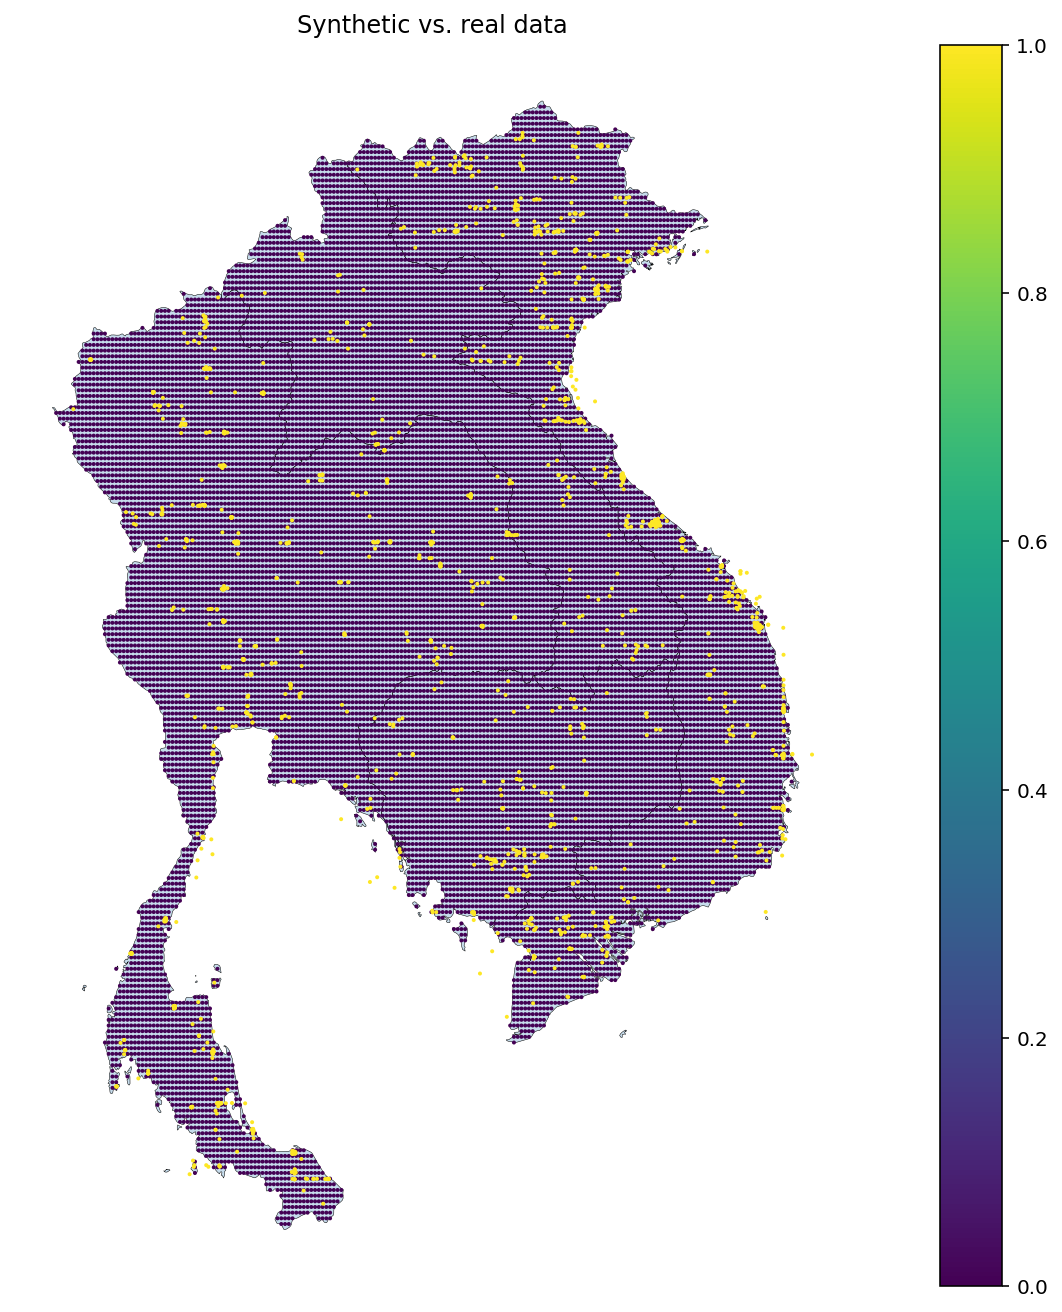

In [20]:
fig, ax = plt.subplots(figsize=(14, 9), dpi=144)
world.query('ISO_A3 in @laos_neighboors ').plot(facecolor='tab:blue', alpha=0.25, ax=ax)
world.query('ISO_A3 in @laos_neighboors').plot(facecolor='none', edgecolor='k', lw=0.25, ax=ax)
# rivers.plot(edgecolor='dodgerblue', lw=0.5, ax=ax)

sea_df.plot('is_disaster', 
                                      markersize=1, 
                                      ax=ax, 
                                      legend=True, 
                                      # categorical=True,
                                      cmap='viridis')
ax.axis('off')
plt.title("Synthetic vs. real data")
plt.show()

In [21]:
#Define cooords
is_disaster_idx , is_disaster = pd.factorize(sea_df["is_disaster"])
ISO_idx, ISO = pd.factorize(sea_df["ISO"]) 
obs_idx = sea_df.index
gp_features = ["lat", "long"]

#Creating idx
xr_idx = xr.Coordinates.from_pandas_multiindex(sea_df.set_index(['ISO', 'Start_Year']).index, 'obs_idx')

#Set coords
coords_sea = {"is_disaster" : is_disaster,
        "obs_idx": obs_idx,
        "ISO": ISO,
        "feature": features_stand,
        "gp_feature":gp_features }

In [22]:
with pm.Model(coords=coords_sea) as model_sea_hsgp:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df_stand[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 35, 35, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)
    
    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd))

    p = HSGP_component
    
    y_hat = pm.Bernoulli('y_hat', logit_p = p, observed=Y, dims='obs_idx')


C:\Users\camil\AppData\Local\Temp\ipykernel_78348\2324413867.py:10: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  ell_params = pm.find_constrained_prior(


In [23]:
# Sample the model
if exists("model_closest_HSGP_long.idata"):
    model_sea_hsgp_idata = az.from_netcdf("model_closest_HSGP_long.idata")

else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_sea_hsgp), backend="jax", gradient_backend='jax')
    model_sea_hsgp_idata = nutpie.sample(compiled_model)
    #Save the idata
    az.to_netcdf(data = model_sea_hsgp_idata, filename= pathlib.Path("model_closest_HSGP_long.idata"))

### Sea predictions

In [24]:
# We sample the predictions
with model_sea_hsgp.copy() as temp_model:
    pm.set_data({"X_gp": sea_point_grid[["lat", "long"]],
                 "Y": np.full(sea_df_stand.shape[0], 0 ),
                },
            coords= {"obs_idx": sea_df_stand.index.values } 
           )

    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))



with freeze_dims_and_data(temp_model):
    model_sea_hsgp_idata_plot = pm.sample_posterior_predictive(model_sea_hsgp_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

Sampling: []


Output()

In [25]:
# Create the geopandas version of the predictions
sea_model_HSGP_predictions = prediction_to_gpd_df(prediction_idata = model_sea_hsgp_idata_plot , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = sea_point_grid)

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\importlib\__init__.py", line 130, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


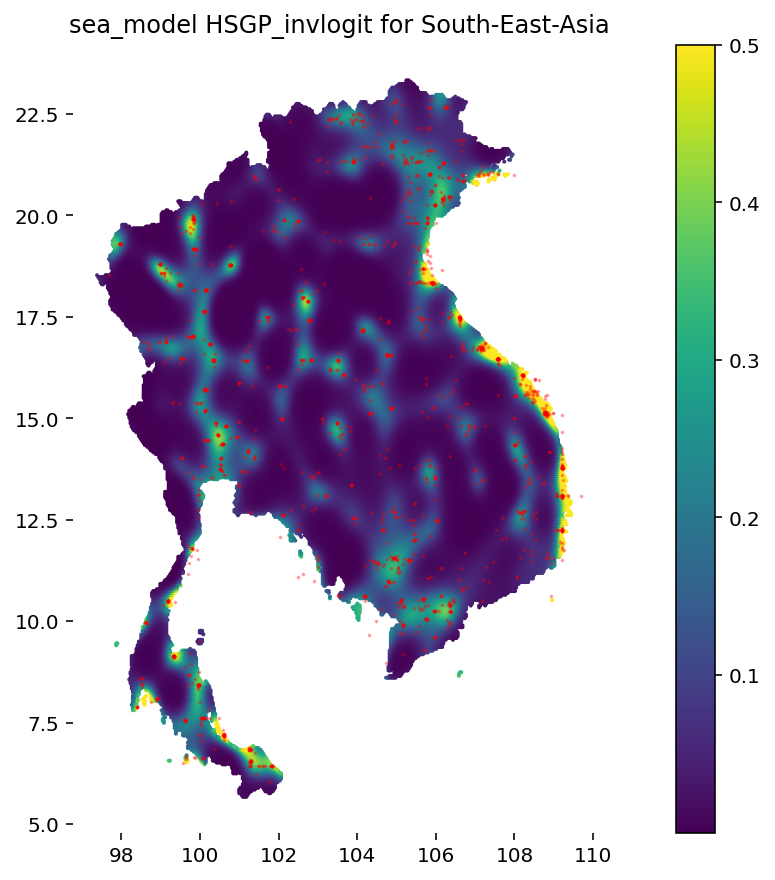

In [26]:
# Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
sea_model_HSGP_predictions["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax,markersize =1 , vmax = 0.5)
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "red",markersize =0.7, )
plt.title("sea_model HSGP_invlogit" )
ax.set_title("sea_model HSGP_invlogit for South-East-Asia" );

### Laos predictions

In [27]:
# We sample the predictions
with model_sea_hsgp.copy() as temp_model:
    pm.set_data({"X_gp": laos_point_grid[["lat", "long"]],
                 "X": laos_point_grid_extended["2020"][features_stand],
                 "Y": np.full(laos_point_grid.shape[0], 0 ),
                 
                },
            coords= {"obs_idx": laos_point_grid.index.values } 
           )

    HSGP_invlogit = pm.Deterministic('HSGP_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))



with freeze_dims_and_data(temp_model):
    model_sea_hsgp_idata_plot_laos = pm.sample_posterior_predictive(model_sea_hsgp_idata, var_names=["HSGP_invlogit","HSGP_component"], 
                                                         compile_kwargs= {"mode" : "JAX" })

Sampling: []


Output()

In [28]:
# Create the geopandas version of the predictions
sea_model_HSGP_predictions_lao = prediction_to_gpd_df(prediction_idata = model_sea_hsgp_idata_plot_laos , 
                     variables = ["HSGP_invlogit", "HSGP_component"] , 
                     points = laos_point_grid )

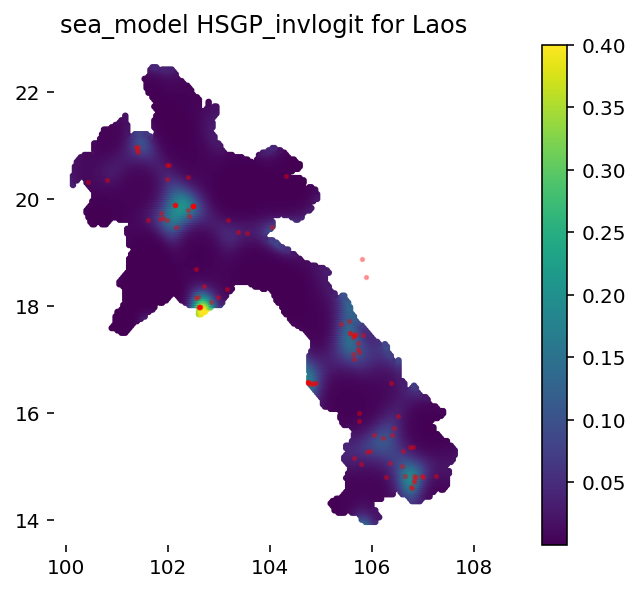

In [29]:
# Plot the predictions
fig, ax = plt.subplots(figsize=(8, 4), dpi= 144 )
sea_model_HSGP_predictions_lao["HSGP_invlogit"].plot("HSGP_invlogit",legend=True, ax=ax ,markersize =5, vmax = 0.4)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r",markersize =3, )
ax.set_title("sea_model HSGP_invlogit for Laos" );

# Model on the SEA data set: Full model

In [30]:
with pm.Model(coords=coords_sea) as model_sea_full:
    #Declare data
    X, Y= add_data(features= features_stand ,  target = "is_disaster", df =  sea_df_stand, )
    ISO_idx_pt = pm.Data("ISO_idx_pt", ISO_idx, dims= ["obs_idx"] )
    
    # # #Country effect
    country_effect = pm.Normal("country_effect", mu = 0, sigma =1, dims = ["ISO"])

    # #Betas
    beta_sigma = [0.1] * 12
    beta = pm.Normal("beta", mu = 0, sigma = beta_sigma, dims = ["feature"])

    # HSGP process
    X_gp = pm.Data("X_gp", sea_df[["lat", "long"]])

    # Prior on the HSGP
    eta = pm.Exponential("eta", scale=2)
    ell_params = pm.find_constrained_prior(
        pm.Lognormal, lower=0.5, upper=10.0, mass=0.95, init_guess={"mu": 1.0, "sigma": 1.0}
    )
    ell = pm.Lognormal("ell", **ell_params, dims=["gp_feature"])
    cov_func = eta**2 * pm.gp.cov.Matern52(input_dim=2, ls=ell)

    m0, m1, c = 35, 35, 1.5
    gp = pm.gp.HSGP(m=[m0, m1], c=c, cov_func=cov_func)

    phi, sqrt_psd = gp.prior_linearized(X=X_gp)

    basis_coeffs = pm.Normal("basis_coeffs", size=gp.n_basis_vectors)
    HSGP_component = pm.Deterministic("HSGP_component", phi @ (basis_coeffs * sqrt_psd),dims= ["obs_idx"])


    #Model mu
    mu = pm.Deterministic("mu", 
                          country_effect[ISO_idx_pt] + 
                          X@beta +
                          HSGP_component , dims= ["obs_idx"] )
    

    # Now define the observed variable separately
    y_hat = pm.Bernoulli('y_hat', logit_p=mu, observed=Y, dims=['obs_idx'])

C:\Users\camil\AppData\Local\Temp\ipykernel_78348\683493846.py:18: FutureWarning: find_constrained_prior is deprecated and will be removed in a future version. Please use maxent function from PreliZ. https://preliz.readthedocs.io/en/latest/api_reference.html#preliz.unidimensional.maxent
  ell_params = pm.find_constrained_prior(


In [31]:
#Set the prior predictions
with freeze_dims_and_data(model_sea_full):
   prior_idata = pm.sample_prior_predictive( compile_kwargs = {"mode":"JAX"})

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2020B704580>), RNG(<Generator(PCG64) at 0x2020F09B060>), RNG(<Generator(PCG64) at 0x2020F09B920>), RNG(<Generator(PCG64) at 0x2020B704120>), RNG(<Generator(PCG64) at 0x2020F09AA40>), RNG(<Generator(PCG64) at 0x202054D3A00>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [basis_coeffs, beta, country_effect, ell, eta, y_hat]


In [32]:
prior_idata.prior_predictive["y_hat"] = prior_idata.prior_predictive["y_hat"].astype(int)

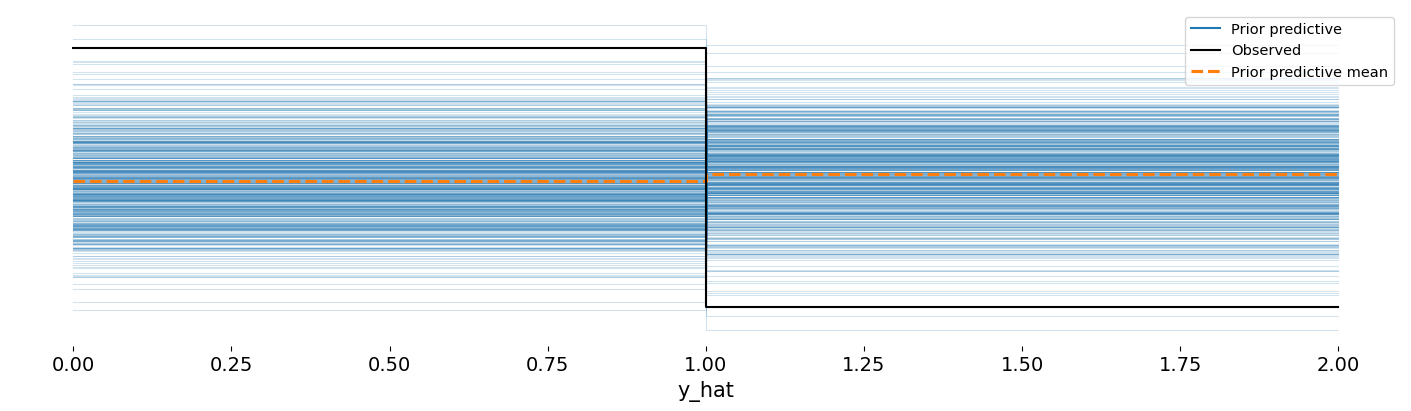

In [33]:
az.plot_ppc(prior_idata, group = "prior", observed = prior_idata.observed_data  );

In [34]:
if exists("model_closest_full_long.idata"):
    model_sea_full_idata = az.from_netcdf("model_closest_full_long.idata")

else:
    compiled_model = nutpie.compile_pymc_model(freeze_dims_and_data(model_sea_full), backend="jax", gradient_backend='jax')
    model_sea_full_idata = nutpie.sample(compiled_model)
    # Save the idata
    az.to_netcdf(data=model_sea_full_idata, filename=pathlib.Path("model_closest_full_long.idata"))


### SEA predictions

In [35]:
az.summary(model_sea_full_idata, var_names=["beta", "eta", "eta_log__", "country_effect"] )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[log_distance_to_river__standardized],-0.495,0.091,-0.664,-0.317,0.001,0.001,5004.0,3724.0,1.00
beta[log_distance_to_coastline__standardized],-0.489,0.092,-0.660,-0.320,0.001,0.001,4310.0,4183.0,1.00
beta[Population__standardized],-0.023,0.098,-0.207,0.162,0.001,0.001,7223.0,4565.0,1.00
beta[co2__standardized],-0.462,0.082,-0.609,-0.301,0.001,0.001,5881.0,4352.0,1.00
beta[precip_deviation__standardized],0.210,0.083,0.056,0.371,0.001,0.001,7939.0,4568.0,1.00
beta[dev_ocean_temp__standardized],0.206,0.065,0.086,0.331,0.001,0.001,8230.0,4351.0,1.00
beta[log_population_density__standardized],-0.014,0.099,-0.203,0.169,0.001,0.001,5855.0,4144.0,1.00
beta[log_gdp_per_cap__standardized],-0.105,0.099,-0.288,0.082,0.001,0.001,7607.0,4289.0,1.00
beta[log_gdp_per_cap__standardized__squared],0.073,0.077,-0.070,0.216,0.001,0.001,6941.0,4127.0,1.00
beta[log_population_density__standardized__squared],-0.048,0.095,-0.226,0.130,0.001,0.001,5766.0,4403.0,1.00


In [36]:
# full model SEA predictions

# Rebuild ISO_idx_sea
ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_sea=  sea_point_grid_extended['2020'].ISO.map(ISO_to_idx.get)

model_sea_full_idata_plot = {}

for year in ["2020",]:
    with model_sea_full.copy() as temp_model:
        #Declare data
        pm.set_data({"X_gp":sea_point_grid_extended[year][["lat", "long"]],
                     "Y": np.full(sea_point_grid_extended[year].shape[0], 0 ),
                     "X": sea_point_grid_extended[year][features_stand],
                     "ISO_idx_pt": ISO_idx_sea
     
                },
            coords= {"obs_idx": sea_point_grid_extended[year].index.values } 
           )
    
        y_hat_invlogit = pm.Deterministic('y_hat_invlogit', pm.math.invlogit(temp_model["y_hat"] ))

        HSGP_component_invlogit = pm.Deterministic('HSGP_component_invlogit', pm.math.invlogit(temp_model["HSGP_component"] ))
    
    
    
    with freeze_dims_and_data(temp_model):
        model_sea_full_idata_plot[year] = pm.sample_posterior_predictive(model_sea_full_idata, var_names=["y_hat_invlogit","y_hat", "HSGP_component",
                                                                                                          "HSGP_component_invlogit",], 
                                                             compile_kwargs= {"mode" : "JAX" })


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2026071DFC0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

In [54]:
model_sea_full_idata_plot['2020'].posterior_predictive

<xarray.Dataset> Size: 10GB
Dimensions:                        (chain: 6, draw: 1000, obs_idx: 78387,
                                    HSGP_component_invlogit_dim_2: 78387,
                                    y_hat_invlogit_dim_2: 78387)
Coordinates:
  * chain                          (chain) int32 24B 0 1 2 3 4 5
  * draw                           (draw) int32 4kB 0 1 2 3 ... 996 997 998 999
  * obs_idx                        (obs_idx) int64 627kB 0 1 2 ... 78385 78386
  * HSGP_component_invlogit_dim_2  (HSGP_component_invlogit_dim_2) int32 314kB ...
  * y_hat_invlogit_dim_2           (y_hat_invlogit_dim_2) int32 314kB 0 ... 7...
Data variables:
    HSGP_component                 (chain, draw, obs_idx) float64 4GB -4.851 ...
    HSGP_component_invlogit        (chain, draw, HSGP_component_invlogit_dim_2) float64 4GB ...
    y_hat                          (chain, draw, obs_idx) bool 470MB False .....
    y_hat_invlogit                 (chain, draw, y_hat_invlogit_dim_2) float32 2GB ...
Attributes:
    created_at:                 2025-02-03T03:30:07.973346+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.19.1

In [37]:
# Create the geopandas version of the predictions
model_sea_full_predictions_geo = {}

for year in ["2020",]:
    model_sea_full_predictions_geo[year] = prediction_to_gpd_df(prediction_idata = model_sea_full_idata_plot[year] , 
                         variables = ["y_hat_invlogit", "y_hat" ,"HSGP_component","HSGP_component_invlogit"  ] , 
                         points = sea_point_grid_extended['2020'] )

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\importlib\__init__.py", line 130, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


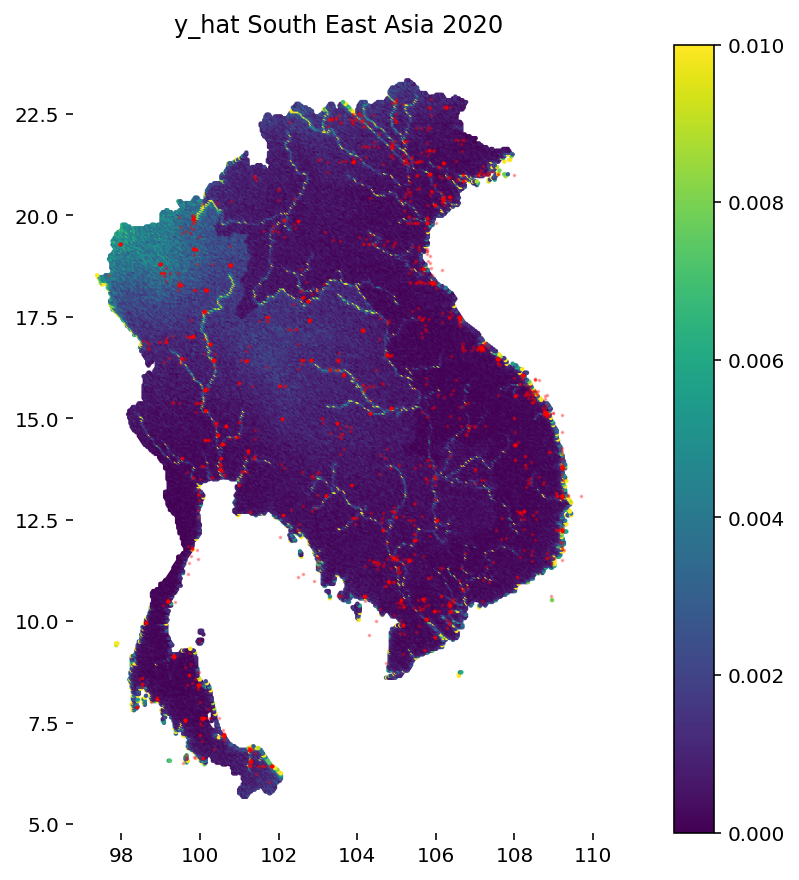

In [38]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
model_sea_full_predictions_geo["2020"]["y_hat"].plot("y_hat",legend=True, ax=ax,markersize =1.5, vmax = 0.01 )
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r", markersize =0.7, )
plt.title("y_hat South East Asia 2020", );

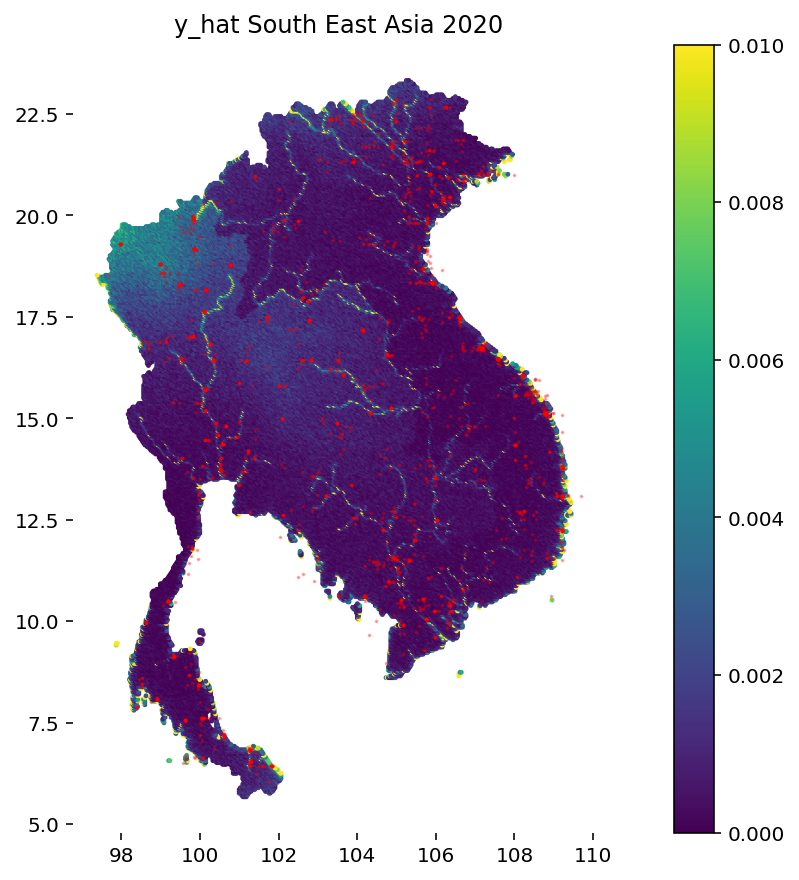

In [39]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(10, 6), dpi= 144 )
model_sea_full_predictions_geo["2020"]["y_hat"].plot("y_hat",legend=True, ax=ax,markersize =2, vmax = 0.01 )
sea_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r", markersize =0.7, )
plt.title("y_hat South East Asia 2020", );

### Laos predictions

In [40]:
# full model SEA predictions

# Rebuild ISO_idx_sea
ISO_to_idx = {name: idx for idx, name in enumerate(ISO)}
ISO_idx_laos =  laos_point_grid_extended['2020'].ISO.map(ISO_to_idx.get)
model_sea_full_idata_plot_laos = {}

for year in ["2020", "2009"]:
    with model_sea_full.copy() as temp_model:
        #Declare data
        pm.set_data({"X_gp": laos_point_grid[["lat", "long"]],
                     "Y": np.full(laos_point_grid_extended['2020'].shape[0], 0 ),
                     "X": laos_point_grid_extended[year][features_stand],
                     "ISO_idx_pt": ISO_idx_laos
     
                },
            coords= {"obs_idx": laos_point_grid_extended['2020'].index.values } 
           )
    
        y_hat_invlogit = pm.Deterministic('y_hat_invlogit', pm.math.invlogit(temp_model["y_hat"] ))
    
    
    
    with freeze_dims_and_data(temp_model):
        model_sea_full_idata_plot_laos[year] = pm.sample_posterior_predictive(model_sea_full_idata, var_names=["y_hat_invlogit","HSGP_component", "y_hat"], 
                                                         compile_kwargs= {"mode" : "JAX" })


C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x20207514740>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\pytensor\link\jax\linker.py:27: UserWarning: The RandomType SharedVariables [RNG(<Generator(PCG64) at 0x2020B7073E0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [y_hat]


Output()

In [41]:
# Create the geopandas version of the predictions
model_sea_full_predictions_geo_laos = {}

for year in ["2020", "2009"]:
    model_sea_full_predictions_geo_laos[year] = prediction_to_gpd_df(prediction_idata = model_sea_full_idata_plot_laos[year] , 
                         variables = ["y_hat_invlogit","HSGP_component", "y_hat"] , 
                         points = laos_point_grid_extended['2020'] )

[autoreload of cutils_ext failed: Traceback (most recent call last):
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\camil\miniforge3\envs\laos-climate-change\Lib\importlib\__init__.py", line 130, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'cutils_ext'
]


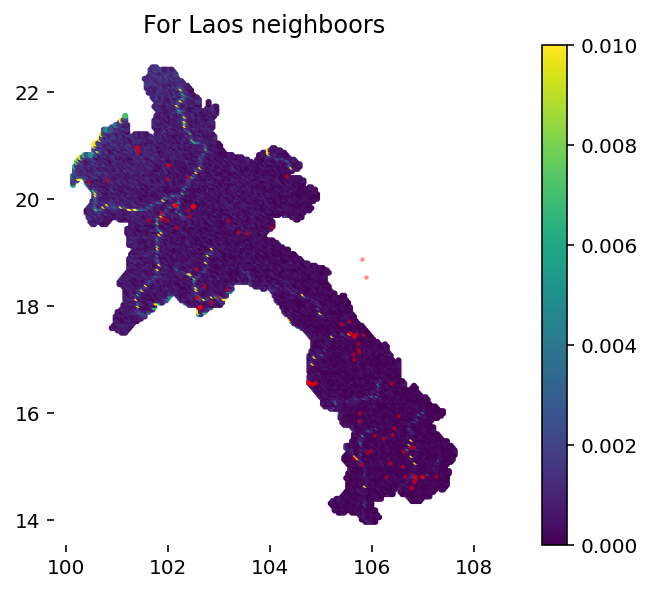

In [42]:
#Plot the predictions
fig, ax = plt.subplots(figsize=(8, 4), dpi= 144 )
model_sea_full_predictions_geo_laos["2020"]["y_hat"].plot("y_hat",legend=True, ax=ax,markersize =4, vmax = 0.01,)
laos_disasters_geo.plot(ax=ax, alpha = 0.3, c = "r", markersize =2, )
plt.title("For Laos neighboors", );

<Axes: >

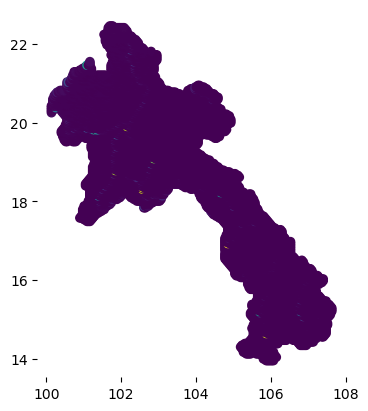

In [43]:
 model_sea_full_predictions_geo_laos[year]["y_hat"].plot("y_hat")